# Playground

> Some initial design ideas

In [ ]:
#| default_exp playground

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import pandas as pd
import itertools

In [ ]:
# Defining the two sets
Ss = ['L', 'R','L2','R2']
Rs = ['L', 'R']

# Generating all combinations by crossing the two sets
combinations_crossed = list(itertools.product(Ss, Rs, repeat=2))

# Convert to DataFrame
df_crossed = pd.DataFrame(combinations_crossed, columns=['S1', 'R1', 'S2', 'R2'])
df_crossed

,S1,R1,S2,R2
0,L,L,L,L
1,L,L,L,R
2,L,L,R,L
3,L,L,R,R
4,L,L,L2,L
...,...,...,...,...
59,R2,R,R,R
60,R2,R,L2,L
61,R2,R,L2,R
62,R2,R,R2,L


In [ ]:
def check_feature_match(row):
    # Creating lists from the first two and the last two columns
    list1 = [row['S1'], row['R1']]
    list2 = [row['S2'], row['R2']]

    # Comparing the lists
    if list1 == list2:
        return "complete_match"
    elif all(item1 != item2 for item1, item2 in zip(list1, list2)):
        return "complete_mismatch"
    else:
        return "partial_match"

In [ ]:
df_permutations['S1'].str[0]

0     L
1     L
2     L
3     L
4     L
5     L
6     L
7     L
8     R
9     R
10    R
11    R
12    R
13    R
14    R
15    R
Name: S1, dtype: object

In [ ]:
def get_possible_trial_sequences(Ss, Rs):
    #Ss = ['L', 'R']
    #Rs = ['L', 'R']
    
    # Generating all combinations by crossing the two sets
    combinations_crossed = list(itertools.product(Ss, Rs, repeat=2))
    
    # Convert to DataFrame
    df_permutations = pd.DataFrame(combinations_crossed, columns=['S1', 'R1', 'S2', 'R2'])
    
    # Convert to DataFrame
    #df_permutations = pd.DataFrame(permutations, columns=['S1', 'R1', 'S2', 'R2'])
    # Adding columns to check if S1 equals R1 and if S2 equals R2
    df_permutations['S1_R1_corresp'] = df_permutations['S1'].str[0] == df_permutations['R1'].str[0]
    df_permutations['S2_R2_corresp'] = df_permutations['S2'].str[0] == df_permutations['R2'].str[0]
    df_permutations['S_R_loc_rep'] = df_permutations['R1'].str[0] == df_permutations['R2'].str[0]
    df_permutations['S_loc_rep'] = df_permutations['S1'].str[0] == df_permutations['S2'].str[0]
    df_permutations['feature_match'] = df_permutations.apply(check_feature_match, axis=1)
    df_permutations['complete_match_mismatch'] = df_permutations.feature_match.isin(["complete_match", "complete_mismatch"])
    df_permutations['cC_iI'] = df_permutations['S1_R1_corresp'] == df_permutations['S2_R2_corresp']
    df_permutations = df_permutations.drop(columns = ['feature_match'])
    
    return df_permutations

Ss = ['L','R']
Rs = ['L', 'R']
possible_sequences = get_possible_trial_sequences(Ss, Rs)
possible_sequences

,S1,R1,S2,R2,S1_R1_corresp,S2_R2_corresp,S_R_loc_rep,S_loc_rep,complete_match_mismatch,cC_iI
0,L,L,L,L,True,True,True,True,True,True
1,L,L,L,R,True,False,False,True,False,False
2,L,L,R,L,True,False,True,False,False,False
3,L,L,R,R,True,True,False,False,True,True
4,L,R,L,L,False,True,False,True,False,False
5,L,R,L,R,False,False,True,True,True,True
6,L,R,R,L,False,False,False,False,True,True
7,L,R,R,R,False,True,True,False,False,False
8,R,L,L,L,False,True,True,False,False,False
9,R,L,L,R,False,False,False,False,True,True


## Todo 

CPU times: user 1min, sys: 322 ms, total: 1min
Wall time: 1min 1s


<Axes: >

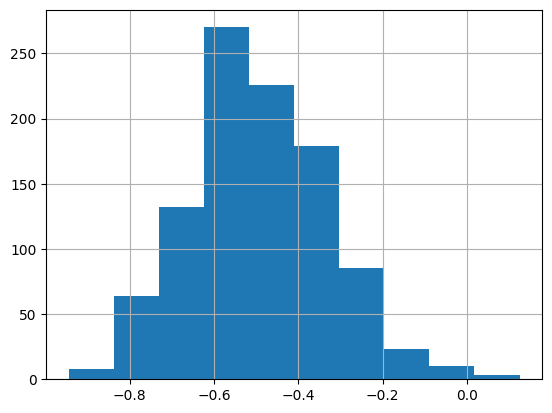

In [ ]:
%%time
def check_balance(N, possible_sequences):
    current = possible_sequences.sample(1)
    trials = []
    trials.append(current)
    for i in range(N-1):
        current = possible_sequences.query(f"(S1=='{current['S2'].values[0]}') and (R1=='{current['R2'].values[0]}')").sample(1)
        trials.append(current)
    trials = pd.concat(trials, ignore_index = True)
    percent_cC_iI = trials.cC_iI.mean()
    agg = trials.set_index(['S1','S2','R1','R2']).groupby('cC_iI').mean()
    return trials, agg, percent_cC_iI
    
Ss = ['L1','L2','R1','R2']

Rs = ['L', 'R']
possible_sequences = get_possible_trial_sequences(Ss, Rs)
N = 30


blocks = []
imbalances = []
for i in range(1000):
    trials, agg, percent_cC_iI = check_balance(N, possible_sequences)
    blocks.append(trials)
    imbalance = agg.loc[False] - agg.loc[True]
    imbalance['percent_cC_iI'] = percent_cC_iI
    imbalances.append(imbalance)
    
df = pd.DataFrame(imbalances)
df.complete_match_mismatch.hist()

In [ ]:
%%time
from joblib import Parallel, delayed

def process_iteration(i):
    trials, agg, percent_cC_iI = check_balance(N, possible_sequences)
    imbalance = agg.loc[False] - agg.loc[True]
    imbalance['percent_cC_iI'] = percent_cC_iI
    return trials, imbalance

# Assuming 'N' and 'possible_sequences' are defined earlier in your code
Ss = ['L1','L2','R1','R2']
Rs = ['L', 'R']
possible_sequences = get_possible_trial_sequences(Ss, Rs)
N = 30

# Parallel execution
results = Parallel(n_jobs=-1)(delayed(process_iteration)(i) for i in range(100000))

# Unpacking results
blocks, imbalances = zip(*results)

In a six stimuli, simon task, there are certain sequences that balance feature repetition and feature unbinding effects between the different conditions required to calculate conflict adaptation.

In [ ]:
df.query("(complete_match_mismatch>-.05) and (complete_match_mismatch<.05)").query("(percent_cC_iI>.45) and (percent_cC_iI<.55)").query("(S_R_loc_rep>-.05) and (S_R_loc_rep<.05)")

,S1_R1_corresp,S2_R2_corresp,S_R_loc_rep,S_loc_rep,complete_match_mismatch,percent_cC_iI


In [ ]:
blocks[42323]

,S1,R1,S2,R2,S1_R1_corresp,S2_R2_corresp,S_R_loc_rep,S_loc_rep,complete_match_mismatch,cC_iI
0,L2,L,R2,L,True,False,True,False,False,False
1,R2,L,L2,L,False,True,True,False,False,False
2,L2,L,L1,L,True,True,True,True,False,True
3,L1,L,L2,R,True,False,False,True,True,False
4,L2,R,R1,L,False,False,False,False,True,True
5,R1,L,R2,L,False,False,True,True,False,True
6,R2,L,R1,R,False,True,False,True,True,False
7,R1,R,L1,L,True,True,False,False,True,True
8,L1,L,L2,L,True,True,True,True,False,True
9,L2,L,R2,R,True,True,False,False,True,True


In [ ]:
df.to_csv('ss4_rs2_30t.csv')

In [ ]:
#ss6_rs2_30t = df
#ss6_rs2_30t.query("(complete_match_mismatch>-.05) and (complete_match_mismatch<.05)").query("(percent_cC_iI>.45) and (percent_cC_iI<.55)").query("(S_R_loc_rep>-.05) and (S_R_loc_rep<.05)")

,S1_R1_corresp,S2_R2_corresp,S_R_loc_rep,S_loc_rep,complete_match_mismatch,percent_cC_iI
936,-0.071429,-0.071429,-0.044643,0.330357,-0.017857,0.466667
2828,0.071429,0.071429,0.008929,0.133929,-0.008929,0.466667
3383,-0.062500,-0.062500,-0.026786,0.401786,0.026786,0.533333
16308,-0.066667,0.000000,0.000000,0.200000,0.000000,0.500000


In [ ]:
blocks[45060]

,S1,R1,S2,R2,S1_R1_corresp,S2_R2_corresp,S_R_loc_rep,S_loc_rep,complete_match_mismatch,cC_iI
0,L1,R,R3,L,False,False,False,False,True,True
1,R3,L,R1,L,False,False,True,True,False,True
2,R1,L,L1,R,False,False,False,False,True,True
3,L1,R,L2,L,False,True,False,True,True,False
4,L2,L,R1,L,True,False,True,False,False,False
5,R1,L,R3,L,False,False,True,True,False,True
6,R3,L,R2,L,False,False,True,True,False,True
7,R2,L,L3,L,False,True,True,False,False,False
8,L3,L,L1,L,True,True,True,True,False,True
9,L1,L,R1,L,True,False,True,False,False,False


In [ ]:
blocks[2036]

,S1,R1,S2,R2,S1_R1_corresp,S2_R2_corresp,S_R_loc_rep,S_loc_rep,complete_match_mismatch,cC_iI
0,L3,R,L2,L,False,True,False,True,True,False
1,L2,L,R3,L,True,False,True,False,False,False
2,R3,L,R1,L,False,False,True,True,False,True
3,R1,L,R2,R,False,True,False,True,True,False
4,R2,R,L3,L,True,True,False,False,True,True
5,L3,L,R1,L,True,False,True,False,False,False
6,R1,L,R2,L,False,False,True,True,False,True
7,R2,L,R3,R,False,True,False,True,True,False
8,R3,R,L2,L,True,True,False,False,True,True
9,L2,L,R2,R,True,True,False,False,True,True


In [ ]:
df.query("(complete_match_mismatch>-.05) and (complete_match_mismatch<.05) ")

In [ ]:
df.query("(complete_match_mismatch>-.05) and (complete_match_mismatch<.05) ")

,S1_R1_corresp,S2_R2_corresp,S_R_loc_rep,S_loc_rep,complete_match_mismatch,percent_cC_iI
4,-0.200000,-0.133333,-0.200000,0.133333,0.000000,0.500000
12,0.187500,0.187500,-0.142857,0.142857,0.017857,0.533333
32,0.111111,0.111111,-0.277778,0.055556,-0.027778,0.600000
103,0.066667,0.133333,-0.133333,-0.066667,0.000000,0.500000
109,-0.185520,-0.108597,-0.167421,-0.244344,-0.027149,0.566667
...,...,...,...,...,...,...
19880,-0.033493,-0.124402,-0.282297,-0.191388,-0.019139,0.633333
19913,0.083333,0.083333,-0.166667,0.166667,0.000000,0.400000
19922,0.055556,0.055556,-0.305556,0.194444,0.027778,0.600000
19926,0.000000,0.000000,-0.055556,0.055556,0.000000,0.400000


In [ ]:
df.query("(complete_match_mismatch>-.05) and (complete_match_mismatch<.05)").query('percent_cC_iI==.5')

,S1_R1_corresp,S2_R2_corresp,S_R_loc_rep,S_loc_rep,complete_match_mismatch,percent_cC_iI
4,-0.200000,-0.133333,-0.200000,0.133333,0.0,0.5
103,0.066667,0.133333,-0.133333,-0.066667,0.0,0.5
418,-0.066667,-0.133333,-0.066667,0.000000,0.0,0.5
719,0.400000,0.466667,-0.200000,0.133333,0.0,0.5
745,0.133333,0.200000,-0.266667,-0.333333,0.0,0.5
...,...,...,...,...,...,...
18636,0.000000,-0.066667,-0.466667,0.000000,0.0,0.5
18801,-0.266667,-0.200000,-0.200000,-0.133333,0.0,0.5
19026,0.066667,0.000000,-0.533333,0.066667,0.0,0.5
19352,0.000000,0.066667,-0.266667,-0.066667,0.0,0.5


In [ ]:
df.query("(complete_match_mismatch>-.05) and (complete_match_mismatch<.05)").query("(percent_cC_iI>.45) and (percent_cC_iI<.55)").query("(S_R_loc_rep>-.05) and (S_R_loc_rep<.05)")

,S1_R1_corresp,S2_R2_corresp,S_R_loc_rep,S_loc_rep,complete_match_mismatch,percent_cC_iI
936,-0.071429,-0.071429,-0.044643,0.330357,-0.017857,0.466667
2828,0.071429,0.071429,0.008929,0.133929,-0.008929,0.466667
3383,-0.062500,-0.062500,-0.026786,0.401786,0.026786,0.533333
16308,-0.066667,0.000000,0.000000,0.200000,0.000000,0.500000


In [ ]:
blocks[16308]

,S1,R1,S2,R2,S1_R1_corresp,S2_R2_corresp,S_R_loc_rep,S_loc_rep,complete_match_mismatch,cC_iI
0,L3,R,R2,L,False,False,False,False,True,True
1,R2,L,L3,L,False,True,True,False,False,False
2,L3,L,R3,L,True,False,True,False,False,False
3,R3,L,L1,R,False,False,False,False,True,True
4,L1,R,L2,R,False,False,True,True,False,True
5,L2,R,L3,L,False,True,False,True,True,False
6,L3,L,L1,L,True,True,True,True,False,True
7,L1,L,R3,L,True,False,True,False,False,False
8,R3,L,L2,L,False,True,True,False,False,False
9,L2,L,R2,L,True,False,True,False,False,False


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()